# Sample Analysis on [House Price Prediction](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
%matplotlib inline

In [2]:
spark = SparkSession.builder \
        .appName('House_Price_Linear_Regression') \
        .getOrCreate()
        
spark

# Load Dataset

In [3]:
data = spark.read.csv('./pyspark-examples/data/house_price.csv', header=True, inferSchema=True).cache()
data = data.replace('NA', None)

data.limit(5).toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


In [4]:
print(data.count(), len(data.columns))

1460 81


In [5]:
data.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |--

In [6]:
# check missing values
def count_missing(df):
    miss_counts = []
    total_cnt = df.count()
    for name in df.columns:
        cnt = df.filter(df[name].isNull()).count()
        if cnt > 0:
            miss_counts.append((name, cnt, cnt / total_cnt))
        
    return miss_counts

missing_counts = count_missing(data)
spark.createDataFrame(missing_counts, ['column', 'miss counts', 'miss ratio']).toPandas()

,column,miss counts,miss ratio
0,LotFrontage,259,0.177397
1,Alley,1369,0.937671
2,MasVnrType,8,0.005479
3,MasVnrArea,8,0.005479
4,BsmtQual,37,0.025342
5,BsmtCond,37,0.025342
6,BsmtExposure,38,0.026027
7,BsmtFinType1,37,0.025342
8,BsmtFinType2,38,0.026027
9,Electrical,1,0.000685


In [7]:
# drop features with too many missing values
useless_cols = ['Id', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
data = data.drop(*useless_cols)

In [8]:
# check distinct values
data.agg(*[F.countDistinct(c).alias(c) for c in data.columns]).toPandas()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,15,5,110,1073,2,4,4,2,5,3,25,9,8,5,8,10,9,112,61,6,8,15,16,4,327,4,5,6,4,4,4,6,637,6,144,780,721,6,5,2,5,753,417,24,861,4,3,4,3,8,4,4,12,7,4,6,97,3,5,441,5,5,3,274,202,120,20,76,8,21,12,5,9,6,663


In [9]:
# check unique values
for name in data.columns:
    unique_values = data.select(name).distinct().collect()
    tmp = []
    for val in unique_values[:20]:
        tmp.append(val[0])
    print(name, '\t', tmp)

MSSubClass 	 [85, 190, 20, 40, 120, 50, 45, 80, 160, 70, 60, 90, 75, 30, 180]
MSZoning 	 ['C (all)', 'RH', 'FV', 'RL', 'RM']
LotFrontage 	 ['51', '124', '54', '101', '138', '69', '112', '42', '73', '87', '64', '30', '34', '59', '160', '85', '52', '35', '71', '98']
LotArea 	 [10206, 11317, 14450, 9900, 18800, 7340, 12046, 34650, 11500, 14536, 11316, 10708, 7879, 8924, 26178, 3000, 2572, 11639, 12393, 19138]
Street 	 ['Pave', 'Grvl']
LotShape 	 ['IR1', 'IR2', 'Reg', 'IR3']
LandContour 	 ['Bnk', 'Low', 'Lvl', 'HLS']
Utilities 	 ['NoSeWa', 'AllPub']
LotConfig 	 ['Inside', 'FR3', 'Corner', 'CulDSac', 'FR2']
LandSlope 	 ['Sev', 'Gtl', 'Mod']
Neighborhood 	 ['Veenker', 'BrkSide', 'NPkVill', 'NridgHt', 'NoRidge', 'NWAmes', 'OldTown', 'Gilbert', 'Somerst', 'Crawfor', 'NAmes', 'IDOTRR', 'Edwards', 'Sawyer', 'StoneBr', 'CollgCr', 'SWISU', 'MeadowV', 'Timber', 'Blmngtn']
Condition1 	 ['PosN', 'RRNe', 'Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosA', 'RRAe']
Condition2 	 ['PosN', 'Artery', 'Feedr'

In [10]:
data.describe().toPandas()

,summary,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,count,1460,1460,1201,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1452,1460,1460,1460,1423,1423,1422,1423,1460,1422,1460,1460,1460,1460,1460,1460,1459,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1379,1379,1379,1460,1460,1379,1379,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
1,mean,56.897260273972606,None,70.04995836802665,10516.828082191782,None,None,None,None,None,None,None,None,None,None,None,6.0993150684931505,5.575342465753424,1971.267808219178,1984.8657534246574,None,None,None,None,None,103.68526170798899,None,None,None,None,None,None,None,443.6397260273973,None,46.54931506849315,567.2404109589041,1057.4294520547944,None,None,None,None,1162.626712328767,346.99246575342465,5.844520547945206,1515.463698630137,0.42534246575342466,0.057534246575342465,1.5650684931506849,0.38287671232876713,2.8664383561643834,1.0465753424657533,None,6.517808219178082,None,0.613013698630137,None,1978.5061638868744,None,1.7671232876712328,472.9801369863014,None,None,None,94.2445205479452,46.66027397260274,21.954109589041096,3.4095890410958902,15.060958904109588,2.758904109589041,43.489041095890414,6.321917808219178,2007.8157534246575,None,None,180921.19589041095
2,stddev,42.30057099381045,None,24.28475177448321,9981.26493237915,None,None,None,None,None,None,None,None,None,None,None,1.3829965467415926,1.1127993367127318,30.202904042525294,20.64540680770938,None,None,None,None,None,181.06620658721647,None,None,None,None,None,None,None,456.0980908409278,None,161.3192728065416,441.8669552924343,438.7053244594709,None,None,None,None,386.5877380410744,436.528435886257,48.62308143352024,525.4803834232024,0.5189106060898061,0.23875264627921197,0.5509158012954318,0.5028853810928912,0.8157780441442279,0.22033819838403076,None,1.6253932905840511,None,0.6446663863122297,None,24.68972476859027,None,0.7473150101111095,213.8048414533803,None,None,None,125.33879435172422,66.2560276766497,61.11914860172857,29.317330556781872,55.75741528187416,40.17730694453021,496.1230244579441,2.7036262083595113,1.3280951205521145,None,None,79442.50288288663
3,min,20,C (all),100,1300,Grvl,IR1,Bnk,AllPub,Corner,Gtl,Blmngtn,Artery,Artery,1Fam,1.5Fin,1,1,1872,1950,Flat,ClyTile,AsbShng,AsbShng,BrkCmn,0,Ex,Ex,BrkTil,Ex,Fa,Av,ALQ,0,ALQ,0,0,0,Floor,Ex,N,FuseA,334,0,0,334,0,0,0,0,0,0,Ex,2,Maj1,0,2Types,1900,Fin,0,0,Ex,Ex,N,0,0,0,0,0,0,0,1,2006,COD,Abnorml,34900
4,max,190,RM,99,215245,Pave,Reg,Lvl,NoSeWa,Inside,Sev,Veenker,RRNn,RRNn,TwnhsE,SLvl,10,9,2010,2010,Shed,WdShngl,WdShing,Wd Shng,Stone,99,TA,TA,Wood,TA,TA,No,Unf,5644,Unf,1474,2336,6110,Wall,TA,Y,SBrkr,4692,2065,572,5642,3,2,3,2,8,3,TA,14,Typ,3,Detchd,2010,Unf,4,1418,TA,TA,Y,857,547,552,508,480,738,15500,12,2010,WD,Partial,755000


# Feature Engineering

In [11]:
# transform LotFrontage into float
data = data.withColumn('LotFrontage', data['LotFrontage'].cast('float'))
data = data.withColumn('MasVnrArea', data['MasVnrArea'].cast('float'))
data = data.withColumn('GarageYrBlt', data['GarageYrBlt'].cast('int'))

In [12]:
# drop outliers
data = data.filter(data['GrLivArea'] < 4000)

In [13]:
# check unique values
for name in data.columns:
    unique_values = data.select(name).distinct().collect()
    tmp = []
    for val in unique_values[:10]:
        tmp.append(val[0])
    print(name, '\t', tmp)

MSSubClass 	 [85, 190, 20, 40, 120, 50, 45, 80, 160, 70]
MSZoning 	 ['C (all)', 'RH', 'FV', 'RL', 'RM']
LotFrontage 	 [64.0, 82.0, 107.0, 47.0, 101.0, 58.0, 39.0, 144.0, 30.0, 105.0]
LotArea 	 [10206, 11317, 14450, 9900, 18800, 7340, 12046, 34650, 11500, 14536]
Street 	 ['Pave', 'Grvl']
LotShape 	 ['IR1', 'IR2', 'Reg', 'IR3']
LandContour 	 ['Bnk', 'Low', 'Lvl', 'HLS']
Utilities 	 ['NoSeWa', 'AllPub']
LotConfig 	 ['Inside', 'FR3', 'Corner', 'CulDSac', 'FR2']
LandSlope 	 ['Sev', 'Gtl', 'Mod']
Neighborhood 	 ['Veenker', 'BrkSide', 'NPkVill', 'NridgHt', 'NoRidge', 'NWAmes', 'OldTown', 'Gilbert', 'Somerst', 'Crawfor']
Condition1 	 ['PosN', 'RRNe', 'Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosA', 'RRAe']
Condition2 	 ['PosN', 'Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosA', 'RRAe']
BldgType 	 ['Twnhs', '1Fam', 'Duplex', '2fmCon', 'TwnhsE']
HouseStyle 	 ['1.5Fin', 'SLvl', 'SFoyer', '2.5Fin', '2Story', '2.5Unf', '1Story', '1.5Unf']
OverallQual 	 [1, 6, 3, 5, 9, 4, 8, 7, 10, 2]
OverallCond 

In [14]:
# check missing values
def count_missing(df):
    miss_counts = []
    total_cnt = df.count()
    for name in df.columns:
        cnt = df.filter(df[name].isNull()).count()
        if cnt > 0:
            types = str(df.schema[name].dataType)
            miss_counts.append((name, cnt, cnt / total_cnt, types))
        
    return miss_counts

missing_counts = count_missing(data)
pd.DataFrame(missing_counts)

,0,1,2,3
0,LotFrontage,259,0.177885,FloatType
1,MasVnrType,8,0.005495,StringType
2,MasVnrArea,8,0.005495,FloatType
3,BsmtQual,37,0.025412,StringType
4,BsmtCond,37,0.025412,StringType
5,BsmtExposure,38,0.026099,StringType
6,BsmtFinType1,37,0.025412,StringType
7,BsmtFinType2,38,0.026099,StringType
8,Electrical,1,0.000687,StringType
9,GarageType,81,0.055632,StringType


In [15]:
# get mean values
data.select('LotFrontage', 'MasVnrArea', 'GarageYrBlt').describe().show()

+-------+-----------------+------------------+-----------------+
|summary|      LotFrontage|        MasVnrArea|      GarageYrBlt|
+-------+-----------------+------------------+-----------------+
|  count|             1197|              1448|             1375|
|   mean|69.69340016708438|102.08770718232044|          1978.44|
| stddev|23.05447376874198|177.33892963724705|24.69273770742376|
|    min|             21.0|               0.0|             1900|
|    max|            313.0|            1600.0|             2010|
+-------+-----------------+------------------+-----------------+



In [16]:
# get model values
names = ['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
         'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

for name in names:
    tmp = data.groupBy(name).count()
    mode = tmp.orderBy(tmp['count'].desc()).collect()[0][0]
    print(name, mode)

MasVnrType None
BsmtQual TA
BsmtCond TA
BsmtExposure No
BsmtFinType1 Unf
BsmtFinType2 Unf
Electrical SBrkr
GarageType Attchd
GarageFinish Unf
GarageQual TA
GarageCond TA


In [17]:
# fill missing values with mean or mode
data = data.na.fill({'LotFrontage': 70, 
                     'MasVnrArea': 102, 
                     'GarageYrBlt': 1978, 
                     'MasVnrType': 'None', 
                     'BsmtQual': 'TA', 
                     'BsmtCond': 'TA', 
                     'BsmtExposure': 'No', 
                     'BsmtFinType1': 'Unf', 
                     'BsmtFinType2': 'Unf', 
                     'Electrical': 'SBrkr', 
                     'GarageType': 'Attchd', 
                     'GarageFinish': 'Unf', 
                     'GarageQual': 'TA', 
                     'GarageCond': 'TA'})

In [18]:
# transform the target variable
data = data.withColumn('SalePrice', F.log(data['SalePrice']))

In [19]:
# create new feature for year information
data = data.withColumn('YearFromBuilt', data['YrSold'] - data['YearBuilt'])
data = data.withColumn('YearFromRemodel', data['YrSold'] - data['YearRemodAdd'])
data = data.withColumn('YearFromGarage', data['YrSold'] - data['GarageYrBlt'])

In [20]:
# get categorical and numerical features
cat_cols = [x[0] for x in data.dtypes if x[1] == 'string']
num_cols = [x[0] for x in data.dtypes if x[1] != 'string' and x[0] != 'SalePrice']

In [21]:
# one-hot encoding
stages = []
for name in cat_cols:
    indexer = StringIndexer(inputCol=name, outputCol=name + '_index')
    encoder = OneHotEncoderEstimator(inputCols=[name + '_index'], outputCols=[name + '_onehot'])
    stages += [indexer, encoder]

In [22]:
# create VectorAssembler
cols = num_cols + [name + '_onehot' for name in cat_cols]
assembler = VectorAssembler(inputCols=cols, outputCol='features')
stages += [assembler]

In [23]:
# create Pipeline
pipeline = Pipeline(stages=stages)
data = pipeline.fit(data).transform(data)

In [24]:
# split into train and test set
(train, test) = data.randomSplit([0.8, 0.2], seed=42)

# Linear Regression

In [25]:
# fit model
lr = LinearRegression(featuresCol='features', labelCol='SalePrice', maxIter=100, fitIntercept=True, 
                      standardization=True, solver='auto', loss='squaredError')

lr_model = lr.fit(train)
lr_train_pred = lr_model.transform(train)
lr_test_pred = lr_model.transform(test)

In [26]:
# model evaluation
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='SalePrice', metricName='rmse')
lr_train_rmse = evaluator.evaluate(lr_train_pred)
lr_test_rmse = evaluator.evaluate(lr_test_pred)

print('Train RMSE: {:6.4f}\t Test RMSE: {:6.4f}'.format(lr_train_rmse, lr_test_rmse))

Train RMSE: 0.0878	 Test RMSE: 0.1507


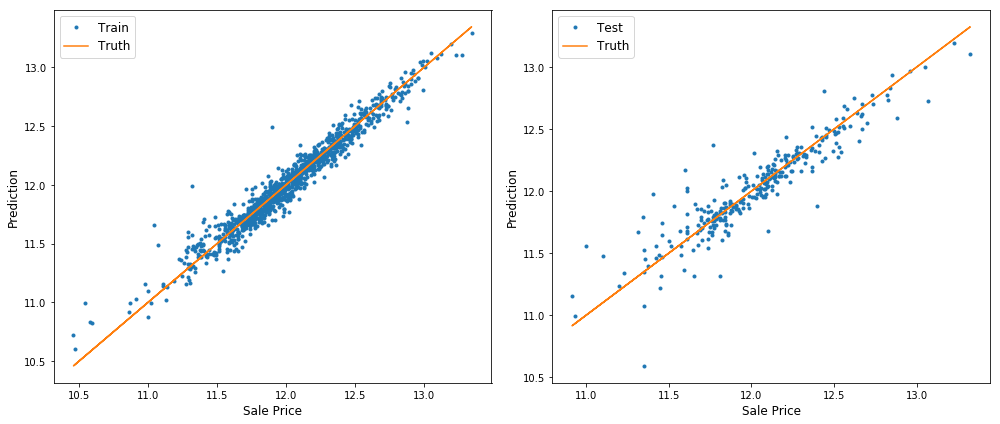

In [27]:
# visualization
lr_train_result = lr_train_pred.select('SalePrice', 'prediction').toPandas()
lr_test_result = lr_test_pred.select('SalePrice', 'prediction').toPandas()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
axs[0].plot(lr_train_result['SalePrice'], lr_train_result['prediction'], '.', label='Train')
axs[0].plot(lr_train_result['SalePrice'], lr_train_result['SalePrice'], label='Truth')
axs[0].set_xlabel('Sale Price', fontsize=12)
axs[0].set_ylabel('Prediction', fontsize=12)
axs[0].legend(fontsize=12)
axs[1].plot(lr_test_result['SalePrice'], lr_test_result['prediction'], '.', label='Test')
axs[1].plot(lr_test_result['SalePrice'], lr_test_result['SalePrice'], label='Truth')
axs[1].set_xlabel('Sale Price', fontsize=12)
axs[1].set_ylabel('Prediction', fontsize=12)
axs[1].legend(fontsize=12)
plt.tight_layout()
plt.show()

# Random Forest

In [28]:
# fit model
rf = RandomForestRegressor(featuresCol='features', labelCol='SalePrice', maxDepth=9, impurity='variance', 
                           subsamplingRate=1.0, seed=42, numTrees=50, featureSubsetStrategy='auto')

rf_model = rf.fit(train)
rf_train_pred = rf_model.transform(train)
rf_test_pred = rf_model.transform(test)

In [29]:
# model evaluation
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='SalePrice', metricName='rmse')
rf_train_rmse = evaluator.evaluate(rf_train_pred)
rf_test_rmse = evaluator.evaluate(rf_test_pred)

print('Train RMSE: {:6.4f}\t Test RMSE: {:6.4f}'.format(rf_train_rmse, rf_test_rmse))

Train RMSE: 0.0674	 Test RMSE: 0.1557


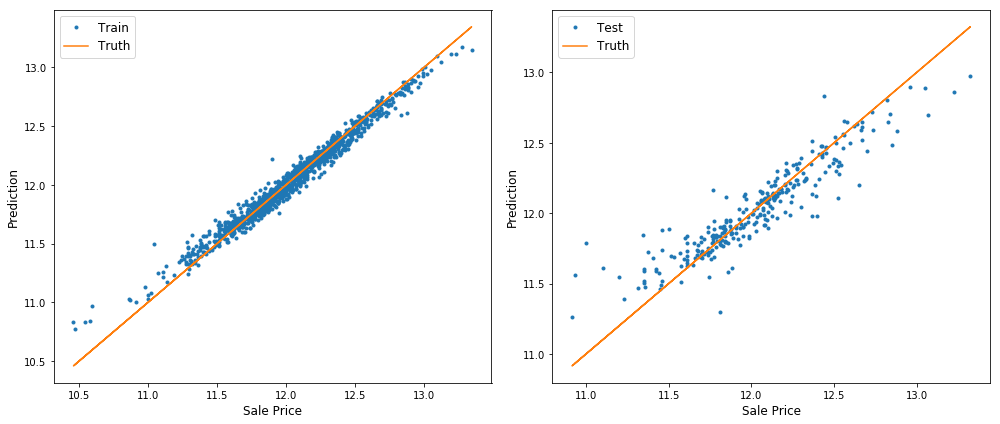

In [30]:
# visualization
rf_train_result = rf_train_pred.select('SalePrice', 'prediction').toPandas()
rf_test_result = rf_test_pred.select('SalePrice', 'prediction').toPandas()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
axs[0].plot(rf_train_result['SalePrice'], rf_train_result['prediction'], '.', label='Train')
axs[0].plot(rf_train_result['SalePrice'], rf_train_result['SalePrice'], label='Truth')
axs[0].set_xlabel('Sale Price', fontsize=12)
axs[0].set_ylabel('Prediction', fontsize=12)
axs[0].legend(fontsize=12)
axs[1].plot(rf_test_result['SalePrice'], rf_test_result['prediction'], '.', label='Test')
axs[1].plot(rf_test_result['SalePrice'], rf_test_result['SalePrice'], label='Truth')
axs[1].set_xlabel('Sale Price', fontsize=12)
axs[1].set_ylabel('Prediction', fontsize=12)
axs[1].legend(fontsize=12)
plt.tight_layout()
plt.show()

# Gradient-Boosted Trees (GBTs)

In [31]:
# fit model
gbt = GBTRegressor(featuresCol='features', labelCol='SalePrice', maxDepth=5, subsamplingRate=1.0, 
                   lossType='squared', maxIter=20, stepSize=0.1, seed=42, featureSubsetStrategy='auto')

gbt_model = gbt.fit(train)
gbt_train_pred = gbt_model.transform(train)
gbt_test_pred = gbt_model.transform(test)

In [32]:
# model evaluation
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='SalePrice', metricName='rmse')
gbt_train_rmse = evaluator.evaluate(gbt_train_pred)
gbt_test_rmse = evaluator.evaluate(gbt_test_pred)

print('Train RMSE: {:6.4f}\t Test RMSE: {:6.4f}'.format(gbt_train_rmse, gbt_test_rmse))

Train RMSE: 0.0817	 Test RMSE: 0.1697


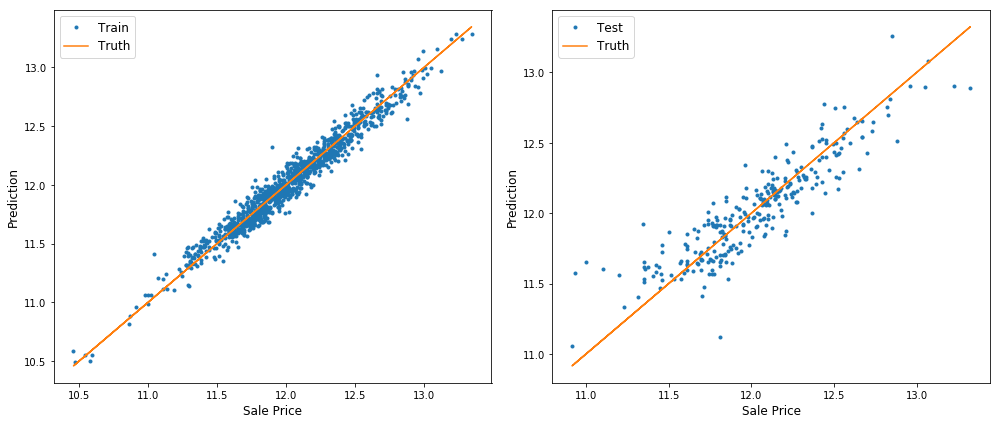

In [33]:
# visualization
gbt_train_result = gbt_train_pred.select('SalePrice', 'prediction').toPandas()
gbt_test_result = gbt_test_pred.select('SalePrice', 'prediction').toPandas()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
axs[0].plot(gbt_train_result['SalePrice'], gbt_train_result['prediction'], '.', label='Train')
axs[0].plot(gbt_train_result['SalePrice'], gbt_train_result['SalePrice'], label='Truth')
axs[0].set_xlabel('Sale Price', fontsize=12)
axs[0].set_ylabel('Prediction', fontsize=12)
axs[0].legend(fontsize=12)
axs[1].plot(gbt_test_result['SalePrice'], gbt_test_result['prediction'], '.', label='Test')
axs[1].plot(gbt_test_result['SalePrice'], gbt_test_result['SalePrice'], label='Truth')
axs[1].set_xlabel('Sale Price', fontsize=12)
axs[1].set_ylabel('Prediction', fontsize=12)
axs[1].legend(fontsize=12)
plt.tight_layout()
plt.show()

In [34]:
spark.stop()